# Exercise 6

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint, chi2

In [36]:
def chi2_test(samples, ps):

    idx, counts = np.unique(samples, return_counts=True)

    n = np.zeros_like(ps)
    n[idx.astype(int)] = counts

    n_exp = ps * np.sum(n)

    T = np.sum((n - n_exp)** 2 / n_exp)

    # test stat follows chi2(k - 1), week 1 slide 10
    return 1 - chi2.cdf(T, len(ps) - 1)

Acceptance rate: 0.6034
P-value: 0.006962149730426637


<BarContainer object of 11 artists>

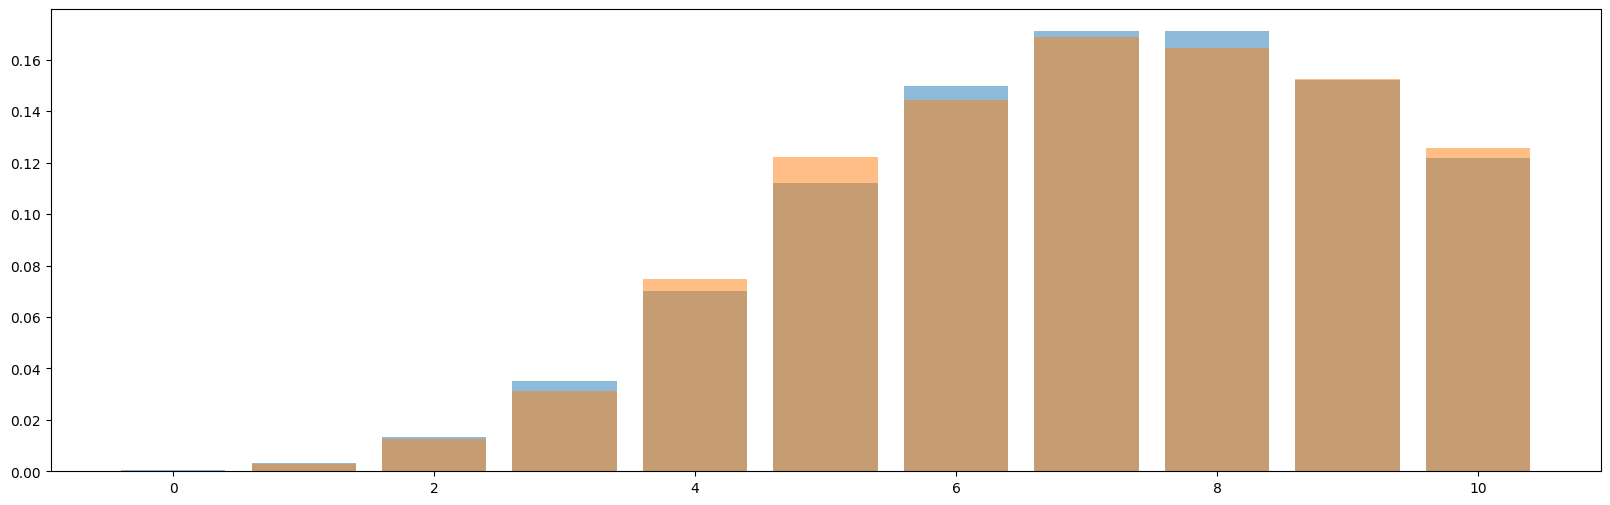

In [ ]:
m = 10

proposal_dist = randint(low=0, high=m + 1)

def factorial(n):
    if n in [0, 1]:
        return 1
    return n * factorial(n - 1)

def target_dist_pdf(i):
    A = 8
    return A**i / factorial(i)


N = 10_000

samples = np.empty(N)
samples[0] = proposal_dist.rvs()
accepted = np.empty(N)
accepted[0] = True

for n in range(1, N):
    proposed_val = proposal_dist.rvs()

    p_accept = min(1, target_dist_pdf(proposed_val) / target_dist_pdf(samples[n - 1]))

    if uniform.rvs() < p_accept:
        samples[n] = proposed_val
        accepted[n] = True
    else:
        samples[n] = samples[n - 1]
        accepted[n] = False

print("Acceptance rate:", np.mean(accepted))

idx, c = np.unique(samples, return_counts=True)

counts = np.zeros(m + 1)
counts[idx.astype(int)] = c
counts /= np.sum(counts)

xs = np.arange(m + 1)
pi = np.array([target_dist_pdf(i) for i in xs])
pi /= np.sum(pi)

print("P-value:", chi2_test(samples[N // 2:], pi))


fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

ax1.bar(xs, pi, alpha=0.5)
ax1.bar(xs, counts, alpha=0.5)
